In [1]:
#instruction to be able to zoom on matplotlib figure
%matplotlib widget 

import sys
sys.path.insert(0,'../source')
import argopy
import xarray as xr
import glob
import numpy as np
import warnings
warnings.filterwarnings("ignore",category=RuntimeWarning)
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import curve_fit
import seawater as sw
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from m_argo_data import open_argo_multi_profile_file, get_argo_launch_date, get_argo_optode_height, get_argo_data_for_WOA
from m_argo_data import get_argo_data_for_NCEP
from m_WOA_data import open_WOA_file, interp_WOA_on_ARGO
from m_NCEP_data import open_NCEP_file, interp_NCEP_on_ARGO, calcul_NCEP_PPOX
from m_NCEP_data import download_NCEP_if_needed
from m_users_fonctions import interp_pres_grid,O2stoO2p, O2ctoO2p, O2ptoO2c, O2ctoO2s,umolkg_to_umolL, diff_time_in_days
from m_model_curve_fit import model_Gain, model_Gain_Derive, model_Gain_CarryOver, model_Gain_Derive_CarryOver

/var/folders/vb/_nx050wx16vc32wc3vf7tkrw000h29/T/ipykernel_3382/4007610002.py:15: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater as sw


In [2]:
#
# Init.
#

# WMO Float (string format)
num_float = '6902802'

# ARGO directory : Directory where you can find 1 directory per WMO ARGO float.
# In the WMO float directory, you can find the Rtraj/Sprof/meta Netcdf Files and the 'profiles' subdirectory
# with the BR/BR and R/D files
rep_data_argo = '/Users/chemon/ARGO_NEW/NEW_LOCODOX/data_test/'

# The WOA file containing the WOA variables (doxywoa,Psatwoa/density/preswoa/PSAL_WOA/TEMP_WOA).
# Ex : doxywoa(time,Depth,lat,lon) with time=12,lat=180,lon=360,Depth=102 : contains the monthly average of doxy
# this file is created by an internal LOPS routine.
#
fic_WOA = '/Users/chemon/ARGO_NEW/LOCODOX/DATA/LOCODOX_EXTERNAL_DATA/WOA/WOA2018_DECAV_monthly_5500_1deg.nc'

# which variable to used :
# which_var = 1 : RAW Data
# which_var = 2 : Adjusted Data
# which_var = 3 : Adjusted Data if available, otherwise Raw Data
which_var = 3

# Min and Max pressure to average WOA and ARGO PPOX
min_pres_interp = 0
max_pres_interp = 25

# Which QC used for pressure, temperature, salinity and oxygen.
pres_qc = [1,2,8]
temp_qc = [1,2,8]
sal_qc = [1,2,8]
doxy_qc = [1,2,3,8]

# NCEP directory : where the NCEP slp/air.sig995/rhum.sig995 can be found or downloaded if needed
rep_NCEP_data= '/Users/chemon/ARGO_NEW/NEW_LOCODOX/NCEP_DATA/'
# NCEP ftp server
ftp_server = 'ftp.cdc.noaa.gov'
# Ncep ftp directory
rep_ftp = 'Datasets/ncep.reanalysis/surface'
# NCEP variables needed.
ncep_variables = ['slp','air.sig995','rhum.sig995']

# ARGO InAir code
code_inair = [699,711,799]
# Argo InWater code
code_inwater = [690,710]
# Min and max pressure to extract the salinity for inwater data (because for inwater data, the pump is off.
# So, we decided to take the salinity from the profile (with the pump on).
min_pres = 0
max_pres = 10

In [3]:
ds_argo_meta = open_argo_multi_profile_file(num_float,rep_data_argo,'meta')
ds_argo_Sprof = open_argo_multi_profile_file(num_float,rep_data_argo,'Sprof')
ds_argo_Rtraj = open_argo_multi_profile_file(num_float,rep_data_argo,'Rtraj')

/Users/chemon/ARGO_NEW/NEW_LOCODOX/data_test/6902802/6902802_meta.nc
/Users/chemon/ARGO_NEW/NEW_LOCODOX/data_test/6902802/6902802_Sprof.nc
/Users/chemon/ARGO_NEW/NEW_LOCODOX/data_test/6902802/6902802_Rtraj.nc


In [4]:
fic_bathy = '/Users/chemon/ARGO_NEW/LOCODOX/DATA/LOCODOX_EXTERNAL_DATA/TOPOGRAPHY/ETOPO2v2c_f4.nc'
ds_bathy = xr.open_dataset(fic_bathy)
ds_bathy = ds_bathy.where((ds_bathy['x']>=ds_argo_Sprof['LONGITUDE'].min()-1) & (ds_bathy['x']<=ds_argo_Sprof['LONGITUDE'].max()+1),drop=True)
ds_bathy = ds_bathy.where((ds_bathy['y']>=ds_argo_Sprof['LATITUDE'].min()-1) & (ds_bathy['x']<=ds_argo_Sprof['LATITUDE'].max()+1),drop=True)
ds_bathy

<xarray.Dataset>
Dimensions:  (y: 1043, x: 624)
Coordinates:
  * x        (x) float32 -58.32 -58.28 -58.25 -58.22 ... -37.62 -37.58 -37.55
  * y        (y) float32 55.25 55.28 55.32 55.35 ... 89.88 89.92 89.95 89.98
Data variables:
    z        (y, x) float32 -207.0 -233.0 -265.0 ... -4.147e+03 -4.147e+03
Attributes:
    Conventions:  COARDS
    title:        
    source:                               -Rd -I2m -ZTLf                     ...
    node_offset:  1

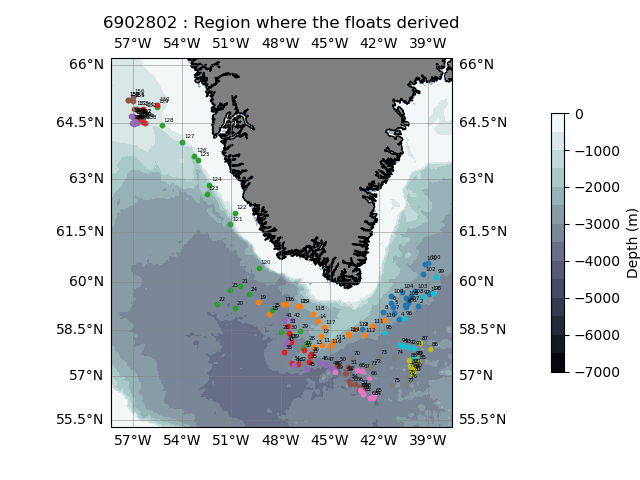

In [5]:
# Position on projection Mercator
depths = np.arange(-7000,500,500)
N = len(depths)
nudge = 0.01  # shift bin edge slightly to include data
boundaries = [min(depths)] + sorted(depths+nudge)  # low to high
norm = matplotlib.colors.BoundaryNorm(boundaries, N)
blues_cm = matplotlib.colormaps['Blues_r'].resampled(N)
colors_depths = blues_cm(norm(depths))

fig = plt.figure()
ax = plt.axes(projection=ccrs.Mercator())
ax.set_extent([ds_argo_Sprof['LONGITUDE'].min()-1,ds_argo_Sprof['LONGITUDE'].max()+1,ds_argo_Sprof['LATITUDE'].min()-1,ds_argo_Sprof['LATITUDE'].max()+1], crs=ccrs.PlateCarree())

# Land in Red
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='grey')
# Ajouter les océans en bleu clair pour visualisation
ax.add_feature(cfeature.OCEAN) #, edgecolor='none', facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE)


cs = ax.contourf(ds_bathy['x'],ds_bathy['y'], ds_bathy['z'], levels=depths.tolist(),transform=ccrs.PlateCarree(),cmap=plt.cm.bone)
sm = plt.cm.ScalarMappable(cmap=blues_cm, norm=norm)
cbar = plt.colorbar(cs, ax=ax, orientation='vertical', label='Depth (m)', shrink=0.7,fraction=0.05, pad=0.2)

# Positions
# Générer une palette de couleurs
longitudes = ds_argo_Sprof['LONGITUDE']
latitudes = ds_argo_Sprof['LATITUDE']
num_positions = len(longitudes)
colors = plt.cm.tab10(np.arange(num_positions) // 10 % 10)  # Une couleur par groupe de 10

# Dessiner les positions avec des couleurs
for i, (lon, lat) in enumerate(zip(longitudes, latitudes)):
    ax.scatter(lon, lat, color=colors[i], s=10, transform=ccrs.PlateCarree(), label=f'Group {i // 10}' if i % 10 == 0 else "")
    ax.text(lon + 0.1, lat + 0.1, ds_argo_Sprof['CYCLE_NUMBER'].values[i], color='black', fontsize=4, transform=ccrs.PlateCarree())

# Ajouter une légende pour les groupes de couleurs
handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles, labels, loc='upper right', title='Groups')

#ax.scatter(ds_argo_Sprof['LONGITUDE'], ds_argo_Sprof['LATITUDE'], color='blue', s=10, transform=ccrs.PlateCarree())
ax.set_xlabel('LONGITUDE')
ax.set_ylabel('LATITUDE')


ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.7, linestyle='-')

plt.title(f'{num_float} : Region where the floats derived') 
plt.show()

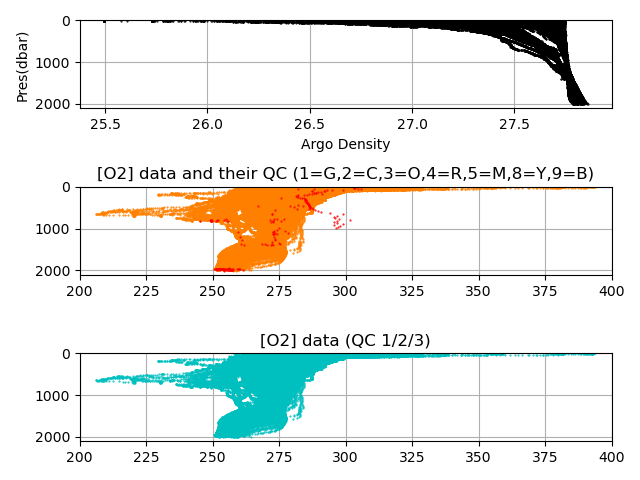

In [6]:
fig, axes = plt.subplots(3,1)

_=axes[0].plot(sw.pden(ds_argo_Sprof['PSAL_ADJUSTED'],ds_argo_Sprof['TEMP_ADJUSTED'],ds_argo_Sprof['PRES_ADJUSTED'],0)-1000,ds_argo_Sprof['PRES_ADJUSTED'],'.k',markersize=1)
axes[0].grid()
axes[0].set_xlabel('Argo Density')
axes[0].set_ylabel('Pres(dbar)')
_=axes[0].set_ylim(0,None)
axes[0].invert_yaxis()

GRBColor = [[0,1,0],[0,1,1],[1,0.5,0],[1,0,0],[1,0,1],[1,1,0],[1,1,1]]
qc_tot = [1,2,3,4,5,8,9]
for i in range(len(GRBColor)):
    _=axes[1].plot(ds_argo_Sprof['DOXY'].where(ds_argo_Sprof['DOXY_QC']==qc_tot[i],drop=False),ds_argo_Sprof['PRES'].where(ds_argo_Sprof['DOXY_QC']==qc_tot[i],drop=False),'.',color=GRBColor[i],markersize=1)

axes[1].grid()
_=axes[1].set_ylim(0,None)
axes[1].invert_yaxis()
_=axes[1].set_xlim(200,400)
axes[1].set_title('[O2] data and their QC (1=G,2=C,3=O,4=R,5=M,8=Y,9=B)')
          
_=axes[2].plot(ds_argo_Sprof['DOXY'].where(ds_argo_Sprof['DOXY_QC'].isin(doxy_qc),drop=True),ds_argo_Sprof['PRES'].where(ds_argo_Sprof['DOXY_QC'].isin([1,2,3]),drop=True),'.c',markersize=1)
axes[2].grid()
_=axes[2].set_ylim(0,None)
axes[2].invert_yaxis()
_=axes[2].set_xlim(200,400)
axes[2].set_title('[O2] data (QC 1/2/3)')

plt.tight_layout()
#plt.subplots_adjust(top=0.85, wspace=5)

plt.show()

PRES
TEMP
PSAL_ADJUSTED


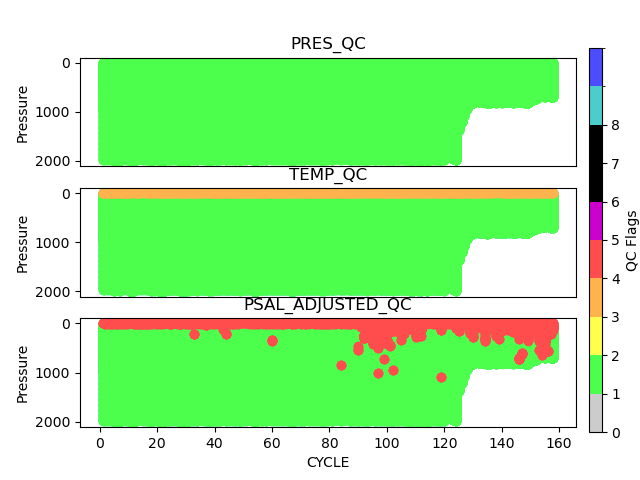

In [7]:
plt.figure()
list_var = ['PRES','TEMP','PSAL_ADJUSTED']
bid = ds_argo_Sprof['CYCLE_NUMBER'].expand_dims(N_LEVELS=np.arange(len(ds_argo_Sprof['N_LEVELS']))).transpose()
Wcolor=[[0.8,0.8,0.8], #  Gray      (QC = 0: no QC was performed)
        [0.3,1, 0.3], # Green     (QC = 1: Good Data)
        [1,1,0.3],  # Yellow    (QC = 2: Probably Good Data)
        [1,0.7,0.3], # Orange    (QC = 3: Bad Data, Potentially Correctable)
        [1,0.3,0.3], # Red       (QC = 4: Bad Data)
        [0.8,0,0.8], # Magenta   (QC = 5: Value Changed)
        [0,0,0],  # Black     (QC = 6: not used)
        [0,0,0],# Black     (QC = 7: not used)
        [0.3,0.8,0.8], # Cyan      (QC = 8: Interpolated Value)
        [0.3,0.3,1]]  # Blue (QC = 9: Missing Value)
cmap = matplotlib.colors.ListedColormap(Wcolor)
bounds = np.arange(len(Wcolor)+1)  # Définir les limites pour chaque couleur
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

tab_qc = [9,8,7,6,0,1,2,3,4,5]
i_plot = 0
for i_var in list_var:
    print(i_var)
    i_plot = i_plot + 1
    plt.subplot(3,1,i_plot)
    for i in tab_qc: #range(len(Wcolor),-1,-1):
        try:
            bid2 = bid.where(ds_argo_Sprof[i_var + '_QC']==i,np.nan)
            bid3 = ds_argo_Sprof['PRES'].where(ds_argo_Sprof[i_var + '_QC']==i,np.nan)
            bid4 = ds_argo_Sprof[i_var + '_QC'].where(ds_argo_Sprof[i_var + '_QC']==i,np.nan)
            plt.scatter(bid2.values,bid3.values,color=Wcolor[i],label=f"QC={i}")
        except:
            pass
        #plt.scatter(bid.where(ds_argo_Sprof[i_var + '_QC']==i,drop=False),ds_argo_Sprof['PRES'].where(ds_argo_Sprof[i_var + '_QC']==i,drop=False),ds_argo_Sprof[i_var + '_QC'].where(ds_argo_Sprof[i_var + '_QC']==i,drop=False),color=Wcolor[i])
    plt.gca().invert_yaxis()
    plt.title(i_var + '_QC')
    plt.ylabel('Pressure')
    if i_plot<=2:
        plt.xticks([])
    if i_plot==3:
        plt.xlabel('CYCLE')


cbar_ax = plt.axes([0.92, 0.1, 0.02, 0.8])  # Position [left, bottom, width, height]
cbar = matplotlib.colorbar.ColorbarBase(cbar_ax,cmap=cmap, norm=norm, boundaries=bounds, ticks=np.arange(0, 9), spacing='proportional', orientation='vertical')
cbar.set_label('QC Flags')

#_=plt.tight_layout()

plt.show()

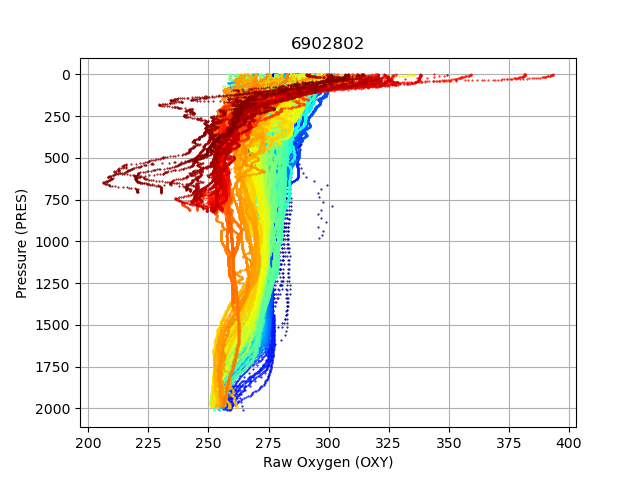

In [8]:
oxy = ds_argo_Sprof['DOXY'].values  # Array de dimensions (N_PROF, N_LEVELS)
pres = ds_argo_Sprof['PRES'].values  # Array de dimensions (N_PROF, N_LEVELS)
cycles = ds_argo_Sprof['CYCLE_NUMBER'].values  # Array de dimensions (N_PROF,)

# Créer une colormap allant du bleu (min cycle) au rouge (max cycle)
norm = plt.Normalize(vmin=np.min(cycles), vmax=np.max(cycles))
cmap = matplotlib.colormaps.get_cmap('jet')  # Dégradé bleu -> rouge
colors = cmap(norm(cycles))  # Couleurs pour chaque profil

# Tracer les données
plt.figure()
for i, cycle in enumerate(cycles):
    plt.plot(ds_argo_Sprof['DOXY'].isel(N_PROF=i), ds_argo_Sprof['PRES'].isel(N_PROF=i), '.-',color=colors[i],markersize=1)


# Inverser l'axe des Y pour que les pressions croissantes descendent
plt.gca().invert_yaxis()

# Ajouter des labels et un titre
plt.xlabel('Raw Oxygen (OXY)')
plt.ylabel('Pressure (PRES)')
plt.title(ds_argo_Sprof['PLATFORM_NUMBER'].values[0])
plt.grid()

plt.show()

In [9]:
launch_date = get_argo_launch_date(ds_argo_meta)
print(launch_date)
optode_height = get_argo_optode_height(ds_argo_meta)
print(optode_height)

2018-07-05T03:29:00.000000000
-0.3


PSAL ADJUSTED Data Used if available, otherwise Raw Data Used
PRES ADJUSTED Data Used if available, otherwise Raw Data Used
TEMP ADJUSTED Data Used if available, otherwise Raw Data Used


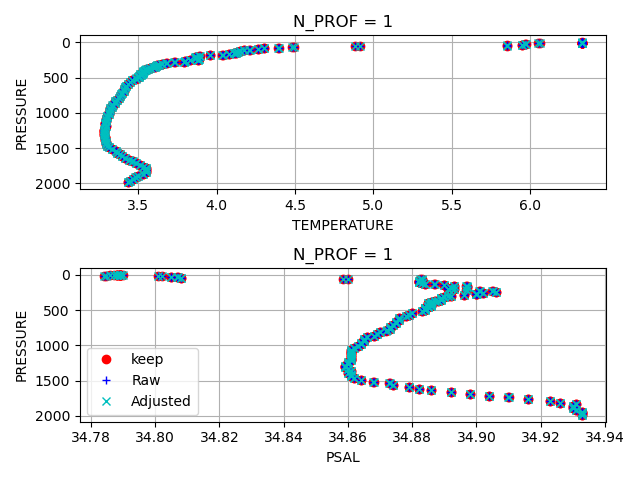

In [10]:
ds_argo = get_argo_data_for_WOA(ds_argo_Sprof,pres_qc,temp_qc,sal_qc,doxy_qc,which_var)

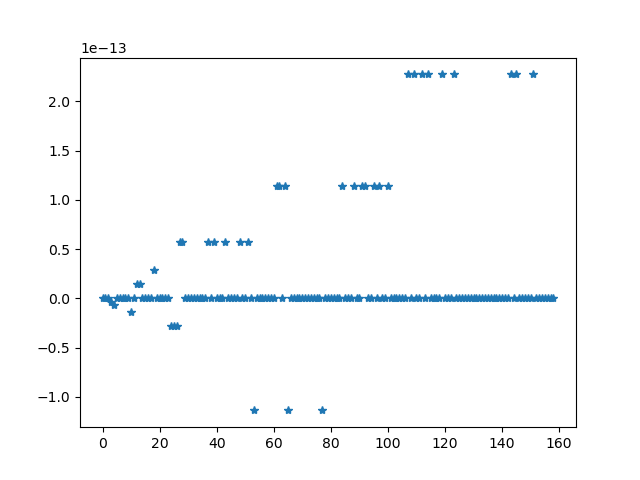

In [11]:
delta_T_WOA1 = (ds_argo['JULD'].values - launch_date)
delta_T_WOA1 = delta_T_WOA1.astype(float)
delta_T_WOA1 = delta_T_WOA1/1e9/86400 # Difference en jour
delta_T_WOA = diff_time_in_days(ds_argo['JULD'].values,launch_date)
plt.figure()
plt.plot(delta_T_WOA1-delta_T_WOA,'*')

In [12]:
ds_woa = open_WOA_file(fic_WOA)
#read_WOA(fic_WOA,dsargo['LONGITUDE'],dsargo['LATITUDE'],dsargo['JULD'])
ds_woa

We force Longitude in [-180 180]


<xarray.Dataset>
Dimensions:    (lat: 180, lon: 360, N_LEVELS: 102, time: 12)
Coordinates:
  * Depth      (N_LEVELS) float64 0.0 5.0 10.0 15.0 ... 5.3e+03 5.4e+03 5.5e+03
  * time       (time) float64 15.0 46.0 75.0 106.0 ... 259.0 289.0 320.0 350.0
Dimensions without coordinates: lat, lon, N_LEVELS
Data variables:
    latitude   (lat) float64 ...
    longitude  (lon) float64 0.5 1.5 2.5 3.5 4.5 ... -4.5 -3.5 -2.5 -1.5 -0.5
    doxywoa    (time, N_LEVELS, lat, lon) float64 ...
    Psatwoa    (time, N_LEVELS, lat, lon) float64 ...
    density    (time, N_LEVELS, lat, lon) float64 ...
    preswoa    (time, N_LEVELS, lat, lon) float64 ...
    PSAL_WOA   (time, N_LEVELS, lat, lon) float64 ...
    TEMP_WOA   (time, N_LEVELS, lat, lon) float64 ...

In [13]:
ds_woa_interp_on_ARGO = interp_WOA_on_ARGO(ds_woa, ds_argo)

WOA time Extrapolation for interpolation

<xarray.Dataset>
Dimensions:   (lat: 180, lon: 360, N_LEVELS: 102, time: 14)
Coordinates:
  * lat       (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon       (lon) float64 0.5 1.5 2.5 3.5 4.5 5.5 ... -4.5 -3.5 -2.5 -1.5 -0.5
  * Depth     (N_LEVELS) float64 0.0 5.0 10.0 15.0 ... 5.3e+03 5.4e+03 5.5e+03
  * time      (time) float64 -15.25 15.0 46.0 75.0 ... 289.0 320.0 350.0 380.2
Dimensions without coordinates: N_LEVELS
Data variables:
    doxywoa   (N_LEVELS, lat, lon, time) float64 nan nan nan nan ... nan nan nan
    Psatwoa   (N_LEVELS, lat, lon, time) float64 nan nan nan nan ... nan nan nan
    density   (N_LEVELS, lat, lon, time) float64 nan nan nan nan ... nan nan nan
    preswoa   (N_LEVELS, lat, lon, time) float64 nan nan nan nan ... nan nan nan
    PSAL_WOA  (N_LEVELS, lat, lon, time) float64 nan nan nan nan ... nan nan nan
    TEMP_WOA  (N_LEVELS, lat, lon, time) float64 nan nan nan nan ... nan nan nan
101.865898

In [14]:
ds_woa_interp_on_ARGO

<xarray.Dataset>
Dimensions:   (N_LEVELS: 102, N_PROF: 159)
Coordinates:
  * Depth     (N_LEVELS) float64 0.0 5.0 10.0 15.0 ... 5.3e+03 5.4e+03 5.5e+03
    lat       (N_PROF) float64 59.62 59.65 59.24 59.24 ... 65.18 65.11 65.1
    lon       (N_PROF) float64 -38.96 -38.86 -39.62 ... -57.0 -57.31 -57.34
    time      (N_PROF) int64 186 188 198 208 218 228 ... 247 257 267 277 287 297
Dimensions without coordinates: N_LEVELS, N_PROF
Data variables:
    doxywoa   (N_LEVELS, N_PROF) float64 308.8 308.2 307.2 304.4 ... nan nan nan
    Psatwoa   (N_LEVELS, N_PROF) float64 105.6 105.6 105.5 104.9 ... nan nan nan
    density   (N_LEVELS, N_PROF) float64 1.027e+03 1.027e+03 ... nan nan
    preswoa   (N_LEVELS, N_PROF) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    PSAL_WOA  (N_LEVELS, N_PROF) float64 34.77 34.77 34.68 34.62 ... nan nan nan
    TEMP_WOA  (N_LEVELS, N_PROF) float64 7.388 7.537 7.82 7.862 ... nan nan nan

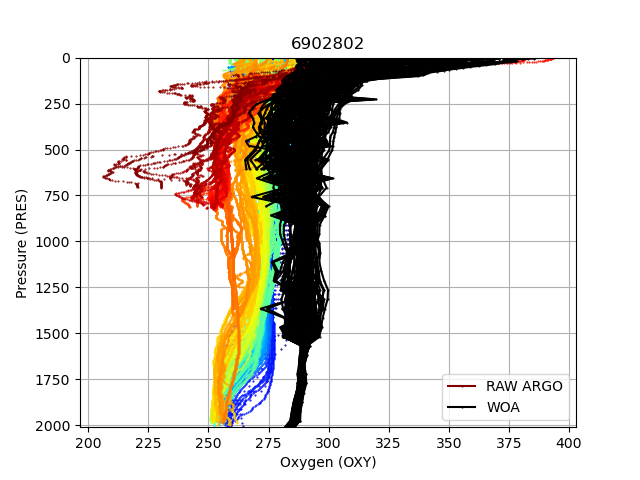

In [15]:
cycles = ds_argo_Sprof['CYCLE_NUMBER'].values  # Array de dimensions (N_PROF,)

# Créer une colormap allant du bleu (min cycle) au rouge (max cycle)
norm = plt.Normalize(vmin=np.min(cycles), vmax=np.max(cycles))
cmap = matplotlib.colormaps.get_cmap('jet')  # Dégradé bleu -> rouge
colors = cmap(norm(cycles))  # Couleurs pour chaque profil

# Tracer les données
plt.figure()
for i, cycle in enumerate(cycles):
                    h = plt.plot(ds_argo['DOXY_ARGO'].isel(N_PROF=i), ds_argo['PRES_ARGO'].isel(N_PROF=i), '.-',color=colors[i],markersize=1,label='RAW ARGO')[0]


plt.ylim([ds_argo['PRES_ARGO'].min(),ds_argo['PRES_ARGO'].max()])
# Inverser l'axe des Y pour que les pressions croissantes descendent
plt.gca().invert_yaxis()

# Ajouter des labels et un titre
plt.xlabel('Oxygen (OXY)')
plt.ylabel('Pressure (PRES)')
plt.title(ds_argo_Sprof['PLATFORM_NUMBER'].values[0])
plt.grid()

h2 = plt.plot(ds_woa_interp_on_ARGO['doxywoa'],ds_woa_interp_on_ARGO['preswoa'],'.-k',markersize=1,label='WOA')[0]

plt.legend(handles=[h,h2])

plt.show()

In [16]:
var_to_interpol = [var for var in ds_woa_interp_on_ARGO.data_vars if "N_LEVELS" in ds_woa_interp_on_ARGO[var].dims]

# Interpolation WOA et ARGO sur une grille reguliere en pression.
ds_woa_interp = interp_pres_grid(min_pres_interp,max_pres_interp,var_to_interpol,ds_woa_interp_on_ARGO,'preswoa','Depth')

var_to_interpol = [var for var in ds_argo.data_vars if "N_LEVELS" in ds_argo[var].dims]
ds_argo_interp = interp_pres_grid(min_pres_interp,max_pres_interp,var_to_interpol,ds_argo,'PRES_ARGO','N_LEVELS')

Interpolation variable doxywoa on a regular pressure grid
Interpolation variable Psatwoa on a regular pressure grid
Interpolation variable density on a regular pressure grid
Interpolation variable preswoa on a regular pressure grid
Interpolation variable PSAL_WOA on a regular pressure grid
Interpolation variable TEMP_WOA on a regular pressure grid
Interpolation variable TEMP_ARGO on a regular pressure grid
Interpolation variable TEMP_ARGO_QC on a regular pressure grid
Interpolation variable PSAL_ARGO on a regular pressure grid
Interpolation variable PSAL_ARGO_QC on a regular pressure grid
Interpolation variable DOXY_ARGO on a regular pressure grid
Interpolation variable DOXY_ARGO_QC on a regular pressure grid
Interpolation variable PRES_ARGO on a regular pressure grid
Interpolation variable PRES_ARGO_QC on a regular pressure grid


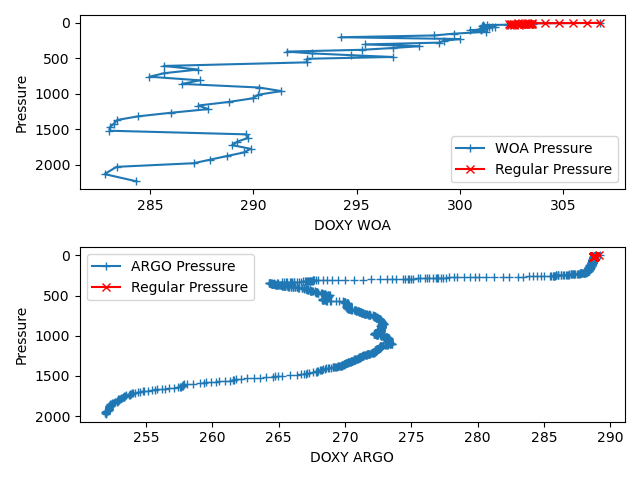

In [17]:
i_prof=100
plt.figure()
plt.subplot(2,1,1)
plt.plot(ds_woa_interp_on_ARGO['doxywoa'].isel(N_PROF=i_prof),ds_woa_interp_on_ARGO['preswoa'].isel(N_PROF=i_prof),'+-')
plt.plot(ds_woa_interp['doxywoa'].isel(N_PROF=i_prof),np.arange(min_pres_interp,max_pres_interp+1,1),'xr-')
plt.gca().invert_yaxis()
plt.grid
plt.xlabel('DOXY WOA')
plt.ylabel('Pressure')
_= plt.legend(['WOA Pressure','Regular Pressure'])
plt.subplot(2,1,2)
plt.plot(ds_argo['DOXY_ARGO'].isel(N_PROF=i_prof),ds_argo['PRES_ARGO'].isel(N_PROF=i_prof),'+-')
plt.plot(ds_argo_interp['DOXY_ARGO'].isel(N_PROF=i_prof),np.arange(min_pres_interp,max_pres_interp+1,1),'xr-')
plt.gca().invert_yaxis()
plt.grid
plt.xlabel('DOXY ARGO')
plt.ylabel('Pressure')
_= plt.legend(['ARGO Pressure','Regular Pressure'])
plt.tight_layout()


In [18]:
ds_woa_interp

<xarray.Dataset>
Dimensions:   (N_PROF: 159, N_LEVELS: 26)
Dimensions without coordinates: N_PROF, N_LEVELS
Data variables:
    doxywoa   (N_PROF, N_LEVELS) float64 308.8 308.7 308.5 ... 335.5 335.3 335.0
    Psatwoa   (N_PROF, N_LEVELS) float64 105.6 105.6 105.5 ... 98.65 98.52 98.39
    density   (N_PROF, N_LEVELS) float64 1.027e+03 1.027e+03 ... 1.026e+03
    preswoa   (N_PROF, N_LEVELS) float64 0.0 1.0 2.0 3.0 ... 22.0 23.0 24.0 25.0
    PSAL_WOA  (N_PROF, N_LEVELS) float64 34.77 34.77 34.77 ... 32.86 32.87 32.88
    TEMP_WOA  (N_PROF, N_LEVELS) float64 7.388 7.368 7.348 ... 1.969 1.971 1.972

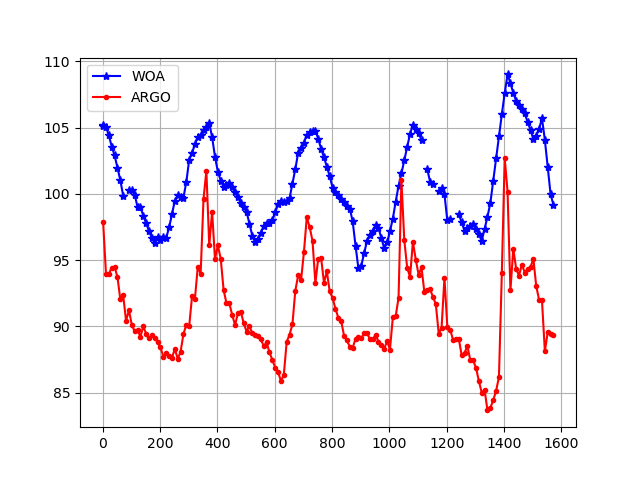

In [19]:
plt.figure()
plt.plot(delta_T_WOA,ds_woa_interp['Psatwoa'].mean(axis=1),'*-b')
psatargo = O2ctoO2s(ds_argo_interp['DOXY_ARGO'],ds_argo_interp['TEMP_ARGO'],ds_argo_interp['PSAL_ARGO'])
_=plt.plot(delta_T_WOA,psatargo.mean(axis=1),'.-r')
plt.grid()
plt.legend(['WOA','ARGO'])

In [20]:
# PPOX WOA.
ppox_WOA = O2stoO2p(ds_woa_interp['Psatwoa'],ds_argo_interp['TEMP_ARGO'],ds_argo_interp['PSAL_ARGO']) 
ppox_WOA_mean = np.nanmean(ppox_WOA,axis=1)

In [21]:
# PPOX ARGO
ana_dens = sw.pden(ds_argo_interp['PSAL_ARGO'],ds_argo_interp['TEMP_ARGO'],np.arange(min_pres_interp,max_pres_interp+1,1),0)
O2_ARGO_umolL = umolkg_to_umolL(ds_argo_interp['DOXY_ARGO'],ds_argo['DOXY_ARGO'].units,ana_dens)

In [22]:
ppox_ARGO = O2ctoO2p(O2_ARGO_umolL,ds_argo_interp['TEMP_ARGO'],ds_argo_interp['PSAL_ARGO']) # On calcule PPOX pour P=0
ppox_ARGO_mean = np.nanmean(ppox_ARGO,axis=1)

In [23]:
# Correction : Gain estimation
initial_guess = 1  # Valeurs initiales pour G 
params_Gain_WOA, covariance = curve_fit(model_Gain, ppox_ARGO_mean, ppox_WOA_mean, p0=initial_guess,nan_policy='omit')
print(params_Gain_WOA)
#params_Gain, covariance = curve_fit(model_Gain, PPOX1, NCEP_PPOX, p0=initial_guess,nan_policy='omit',method='dogbox')
#print(params_Gain)

initial_guess = 1  # Valeurs initiales pour G 
params_Gain_WOA, covariance = curve_fit(model_Gain, ppox_ARGO_mean/ppox_ARGO_mean, ppox_WOA_mean/ppox_ARGO_mean, p0=initial_guess,nan_policy='omit')
print(params_Gain_WOA)


[1.07454207]
[1.07579126]


In [24]:
# Correction : Gain and Drift Time estimation
initial_guess = [1, 0]  # Valeurs initiales pour G et D et C
params_Gain_Derive_WOA, covariance,info,mesg,ier = curve_fit(model_Gain_Derive, [ppox_ARGO_mean,delta_T_WOA], ppox_WOA_mean, p0=initial_guess,nan_policy='omit',full_output=True)
print(params_Gain_Derive_WOA)

initial_guess = [1, 0]  # Valeurs initiales pour G et D et C
params_Gain_Derive_WOA, covariance,info,mesg,ier = curve_fit(model_Gain_Derive, [ppox_ARGO_mean/ppox_ARGO_mean,delta_T_WOA], ppox_WOA_mean/ppox_ARGO_mean, p0=initial_guess,nan_policy='omit',full_output=True)
print(params_Gain_Derive_WOA)

[1.05946271 0.66569555]
[1.05995775 0.6978205 ]


In [25]:
# NCEP Correction
# Download NCEP Data
#download_NCEP_if_needed(ds_argo['JULD'],ftp_server,rep_ftp,rep_NCEP_data,ncep_variables)
#annee_to_download = [min(ds_argo['JULD'].dt.year).values,max(ds_argo['JULD'].dt.year).values]
#download_NCEP_force(annee_to_download,ftp_server,rep_ftp,rep_NCEP_data,ncep_variables)

We look for PSAL in Sprof near the surface between 0 and 10
We look for PSAL_ADJUSTED in Sprof near the surface between 0 and 10


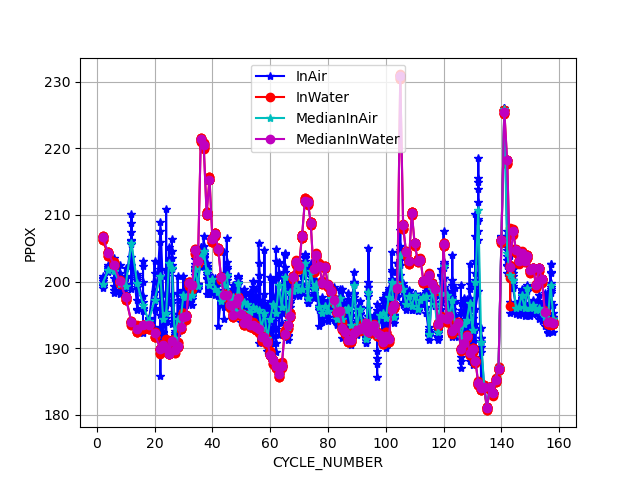

PSAL_ADJUSTED is used if exists, otherwise PSAL.



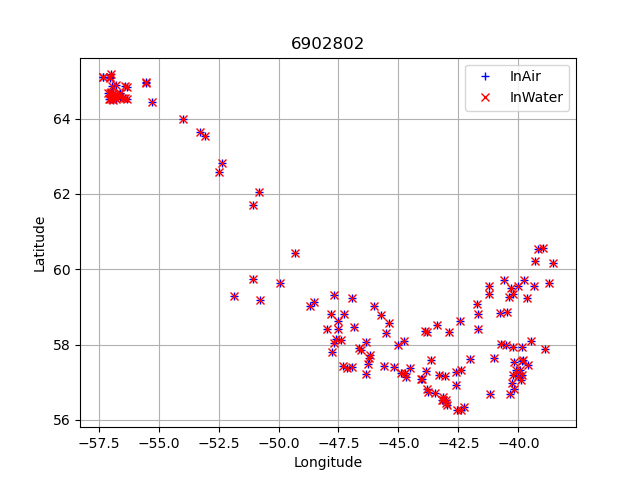

In [26]:
dsair,dsinwater = get_argo_data_for_NCEP(ds_argo_Rtraj,ds_argo_Sprof,which_var,code_inair,code_inwater,min_pres,max_pres)

In [27]:
ds_NCEP_air,ds_NCEP_rhum, ds_NCEP_slp = open_NCEP_file(rep_NCEP_data)
ds_NCEP_air,ds_NCEP_rhum,ds_NCEP_slp = interp_NCEP_on_ARGO(ds_NCEP_air,ds_NCEP_rhum,ds_NCEP_slp,dsair['LONGITUDE_ARGO'],dsair['LATITUDE_ARGO'],dsair['JULD'])

In [28]:
z0q = 1e-4
NCEP_PPOX = calcul_NCEP_PPOX(dsinwater,ds_NCEP_air,ds_NCEP_rhum,ds_NCEP_slp,optode_height,z0q)

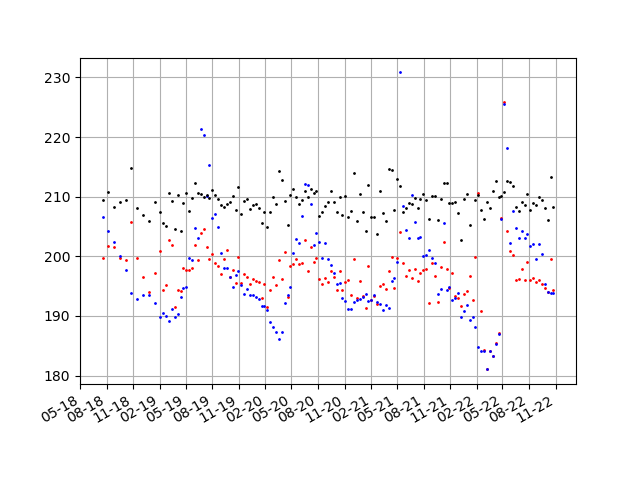

In [29]:
plt.figure()
plt.plot(dsair['JULD'],dsair['PPOX_DOXY'],'.r',markersize=2)
plt.plot(dsinwater['JULD'],dsinwater['PPOX_DOXY'],'.b',markersize=2)
plt.plot(dsair['JULD'],NCEP_PPOX,'.k',markersize=2)
plt.grid()

#plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m-%Y'))
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m-%y'))
plt.gca().xaxis.set_major_locator(matplotlib.dates.MonthLocator(interval=3))  
plt.gcf().autofmt_xdate()  

In [30]:
#delta_T_NCEP1 = (dsair['JULD'].values - launch_date)
#delta_T_NCEP1 = delta_T_NCEP1.astype(float)
#delta_T_NCEP1 = delta_T_NCEP1/1e9/86400 # Difference en jour
delta_T_NCEP = diff_time_in_days(dsair['JULD'].values,launch_date)
#plt.figure()
#plt.plot(delta_T_NCEP-delta_T_NCEP1,'+b')

In [31]:
PPOX1 = dsair['PPOX_DOXY'].values
PPOX2 = dsinwater['PPOX_DOXY'].values
initial_guess = 1
params_Gain_NCEP, covariance = curve_fit(model_Gain, PPOX1/PPOX1, NCEP_PPOX/PPOX1, p0=initial_guess,nan_policy='omit')

initial_guess = [1, 0]  # Valeurs initiales pour G et C
params_Gain_NCEP_CarryOver, covariance = curve_fit(model_Gain_CarryOver, [PPOX1,PPOX2], NCEP_PPOX, p0=initial_guess,nan_policy='omit')

In [32]:
initial_guess = [1, 0]  # Valeurs initiales pour G et D et C
params_Gain_Derive_NCEP, covariance,info,mesg,ier = curve_fit(model_Gain_Derive, [PPOX1/PPOX1,delta_T_NCEP], NCEP_PPOX/PPOX1, p0=initial_guess,nan_policy='omit',full_output=True)
initial_guess = [1, 0, 0]  # Valeurs initiales pour G et D et C
params_Gain_Derive_NCEP_CarryOver, covariance = curve_fit(model_Gain_Derive_CarryOver, [PPOX1,PPOX2,delta_T_NCEP], NCEP_PPOX, p0=initial_guess,nan_policy='omit')

In [34]:
print(params_Gain_WOA)
print(params_Gain_NCEP)
print(params_Gain_NCEP_CarryOver[0])
print(params_Gain_Derive_WOA)
print(params_Gain_Derive_NCEP)
print(params_Gain_Derive_NCEP_CarryOver[0],params_Gain_Derive_NCEP_CarryOver[2])
gain_CarryOver = np.array([params_Gain_NCEP_CarryOver[0]])
gain_Derive_CarryOver = np.array([params_Gain_Derive_NCEP_CarryOver[0], params_Gain_Derive_NCEP_CarryOver[2]])
print(gain_CarryOver)
print(gain_Derive_CarryOver)

[1.07579126]
[1.06188802]
1.0609534247223742
[1.05995775 0.6978205 ]
[1.0499345  0.49749727]
1.050412530549421 0.4429726560162914
[1.06095342]
[1.05041253 0.44297266]


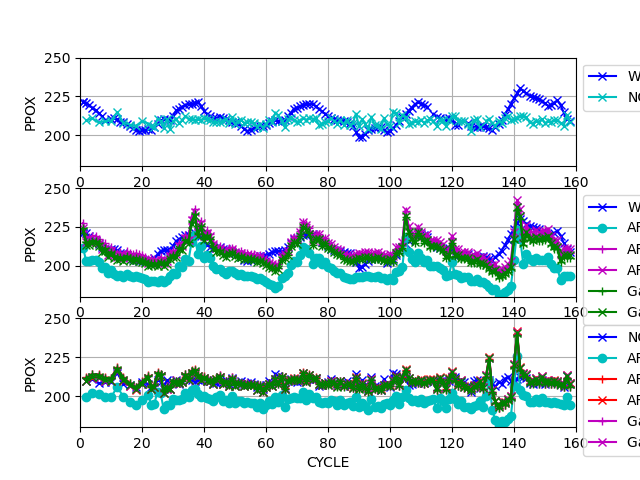

In [35]:
plt.figure()
plt.subplot(3,1,1)
plt.plot(ds_argo['CYCLE_NUMBER'],ppox_WOA_mean,'x-b')
plt.plot(dsair['CYCLE_NUMBER'],NCEP_PPOX,'x-c')
plt.ylim([180,250])
plt.xlim([0,160])
plt.grid()
plt.xlabel('CYCLE')
plt.ylabel('PPOX')
plt.legend(['WOA','NCEP'],loc='upper left',bbox_to_anchor=(1,1))

plt.subplot(3,1,2)
plt.plot(ds_argo['CYCLE_NUMBER'],ppox_WOA_mean,'x-b')
plt.plot(ds_argo['CYCLE_NUMBER'],ppox_ARGO_mean,'o-c')
plt.plot(ds_argo['CYCLE_NUMBER'],model_Gain(ppox_ARGO_mean,*params_Gain_WOA),'+m-')
plt.plot(ds_argo['CYCLE_NUMBER'],model_Gain_Derive([ppox_ARGO_mean,delta_T_WOA],*params_Gain_Derive_WOA),'xm-')
plt.plot(ds_argo['CYCLE_NUMBER'],ppox_ARGO_mean* 1.0605,'+g-')
plt.plot(ds_argo['CYCLE_NUMBER'],ppox_ARGO_mean* (1.0513 * (1+delta_T_WOA/365*0.389/100)),'xg-')
plt.xlabel('CYCLE')
plt.ylabel('PPOX')
plt.grid()
plt.ylim([180,250])
plt.xlim([0,160])
plt.legend(['WOA','ARGO','ARGO_gain_WOA','ARGO_Gain_Derive_WOA','Gain Bittig','GainDerive Bittig'],loc='upper left',bbox_to_anchor=(1,1))
plt.subplot(3,1,3)
plt.plot(dsair['CYCLE_NUMBER'],NCEP_PPOX,'x-b')
plt.plot(dsair['CYCLE_NUMBER'],PPOX1,'o-c')
plt.plot(dsair['CYCLE_NUMBER'],model_Gain(PPOX1,*params_Gain_NCEP),'+r-')
plt.plot(dsair['CYCLE_NUMBER'],model_Gain_Derive([PPOX1,delta_T_NCEP],*params_Gain_Derive_NCEP),'xr-')
plt.plot(dsair['CYCLE_NUMBER'],model_Gain(PPOX1,*gain_CarryOver),'+m-')
plt.plot(dsair['CYCLE_NUMBER'],model_Gain_Derive([PPOX1,delta_T_NCEP],*gain_Derive_CarryOver),'xm-')
plt.plot(dsair['CYCLE_NUMBER'],PPOX1* 1.0605,'+g-')
plt.plot(dsair['CYCLE_NUMBER'],PPOX1* (1.0513 * (1+delta_T_NCEP/365*0.389/100)),'xg-')
plt.xlabel('CYCLE')
plt.ylabel('PPOX')
plt.grid()
plt.ylim([180,250])
plt.xlim([0,160])
plt.legend(['NCEP','ARGO','ARGO_gain_NCEP','ARGO_Gain_Derive_NCEP','Gain Bittig','GainDerive Bittig'],loc='upper left',bbox_to_anchor=(1,1))




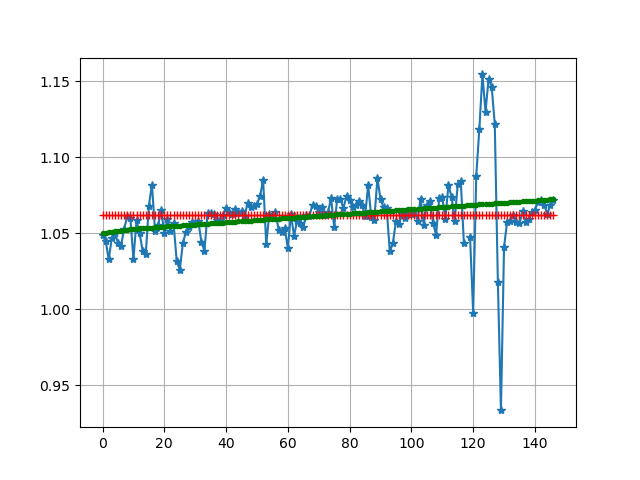

In [36]:
plt.figure()
plt.plot(NCEP_PPOX/PPOX1,'*-')
plt.plot(model_Gain(PPOX1,*params_Gain_NCEP)/PPOX1,'+r')
plt.plot(model_Gain_Derive([PPOX1,delta_T_NCEP],*params_Gain_Derive_NCEP)/PPOX1,'.g')
plt.grid()

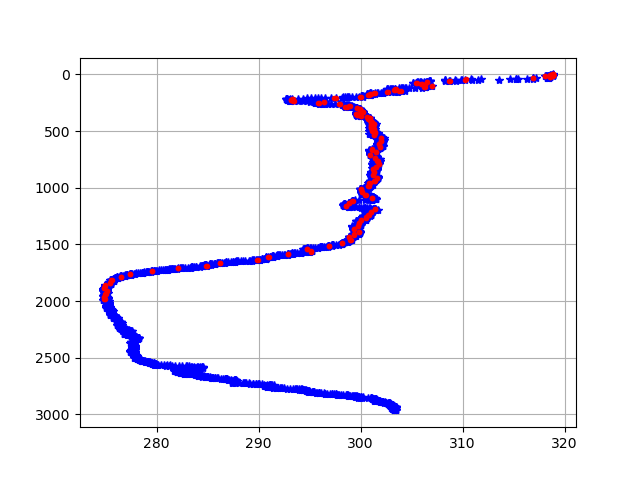

In [38]:
# Comparison between 6902802 Cycle 1 and  OVID18 CTD 81
ds_ovid18 = xr.open_dataset('/Volumes/lpo5/HYDROCEAN/MLT_NC/LPO/OVIDE/ovid18_PRES.nc')
ds_ovid18 = ds_ovid18.where(ds_ovid18['STATION_NUMBER']==81,drop=True)
ds_cycle1 = ds_argo_Sprof.where((ds_argo_Sprof['CYCLE_NUMBER']==1) & (ds_argo_Sprof['DIRECTION']=='A'),drop=True)
oxy_ovid18_interp = np.interp(ds_cycle1['PRES'],ds_ovid18['PRES'].isel(N_PROF=0),ds_ovid18['OXYK'].isel(N_PROF=0))
plt.figure()
plt.plot(ds_ovid18['OXYK'],ds_ovid18['PRES'],'*-b')
plt.plot(oxy_ovid18_interp,ds_cycle1['PRES'],'.r-')
plt.gca().invert_yaxis()
plt.grid()

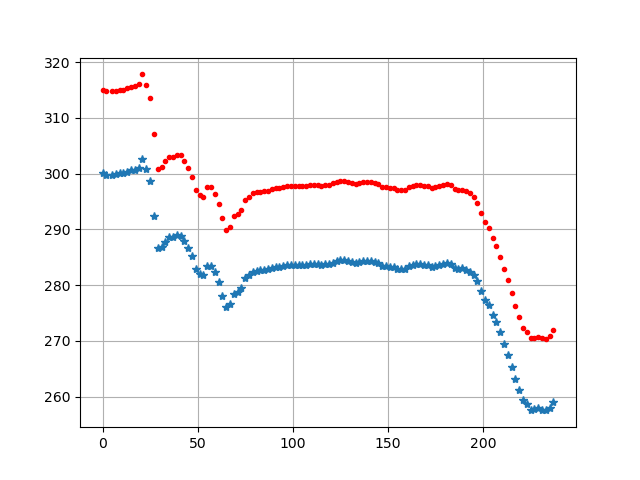

In [39]:
delta_T_Sprof = diff_time_in_days(ds_cycle1['JULD'].values,launch_date)
tab_delta_T= np.tile(delta_T_Sprof,(1,len(ds_cycle1['N_LEVELS'])))
plt.figure()
_=plt.plot(ds_cycle1['DOXY'].isel(N_PROF=0).values,'*-')
_=plt.plot(model_Gain_Derive([ds_cycle1['DOXY'].isel(N_PROF=0).values,tab_delta_T],*params_Gain_Derive_NCEP).transpose(),'.-r')
plt.grid()

In [40]:
initial_guess = 1
#params_Gain_CTD, covariance = curve_fit(model_Gain, model_Gain_Derive([ds_cycle1['DOXY'].isel(N_PROF=0).values,tab_delta_T],*params_Gain_Derive_NCEP), oxy_ovid18_interp, p0=initial_guess,nan_policy='omit')
cycle1_corr = model_Gain_Derive([ds_cycle1['DOXY'].isel(N_PROF=0).values,tab_delta_T],*params_Gain_Derive_NCEP)
#params_Gain_CTD, covariance = curve_fit(model_Gain, cycle1_corr, ds_cycle1['DOXY'].isel(N_PROF=0).values, p0=initial_guess,nan_policy='omit')
#params_Gain_CTD, covariance = curve_fit(model_Gain, ds_cycle1['DOXY'].isel(N_PROF=0).values, ds_cycle1['DOXY'].isel(N_PROF=0).values, p0=initial_guess,nan_policy='omit')
params_Gain_CTD, covariance = curve_fit(model_Gain, cycle1_corr[0], oxy_ovid18_interp[0], p0=initial_guess,nan_policy='omit')
print(params_Gain_CTD)
cycle1_corr2 = cycle1_corr * params_Gain_CTD


[1.01113838]


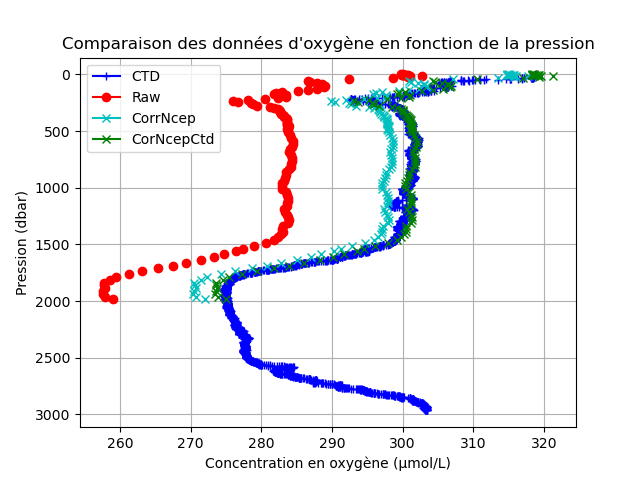

In [41]:
plt.figure()

# Traçage des courbes et ajout des labels pour la légende
line1 = plt.plot(ds_ovid18['OXYK'], ds_ovid18['PRES'], '+-b', label='CTD')[0]
line2 = plt.plot(ds_cycle1['DOXY'], ds_cycle1['PRES'], 'or-', label='Raw')[0]
line3 = plt.plot(cycle1_corr, ds_cycle1['PRES'], 'xc-', label='CorrNcep')[0]
line4 = plt.plot(cycle1_corr2, ds_cycle1['PRES'], 'xg-', label='CorNcepCtd')[0]

# Ajout de la grille et inversion de l'axe y
plt.grid()
plt.gca().invert_yaxis()

# Ajout des labels et du titre
plt.xlabel('Concentration en oxygène (µmol/L)')  # Ajustez si nécessaire
plt.ylabel('Pression (dbar)')  # Ajustez si nécessaire
plt.title('Comparaison des données d\'oxygène en fonction de la pression')

# Affichage de la légende
plt.legend(handles=[line1, line2, line3, line4])
# Affichage du graphique
plt.show()

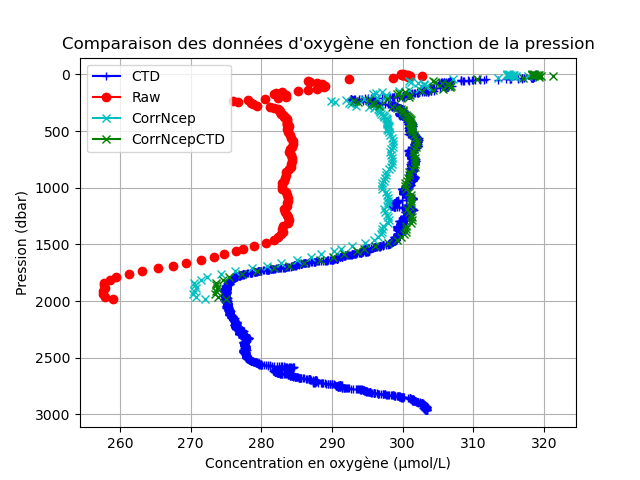

In [59]:
# Correction for all profiles.
delta_T_Sprof = diff_time_in_days(ds_argo_Sprof['JULD'].values,launch_date)

for i in range(1,len(ds_argo_Sprof['CYCLE_NUMBER'])):
    tab_delta_T= np.tile(delta_T_Sprof[i],(1,len(ds_argo_Sprof['N_LEVELS'])))
    new_values = params_Gain_CTD * model_Gain_Derive([ds_argo_Sprof['DOXY'].isel(N_PROF=i).values, tab_delta_T], *params_Gain_Derive_NCEP)[0]
    ds_argo_Sprof['DOXY_ADJUSTED'].loc[dict(N_PROF=i)] = new_values

plt.figure()
# Traçage des courbes et ajout des labels pour la légende
line1 = plt.plot(ds_ovid18['OXYK'], ds_ovid18['PRES'], '+-b', label='CTD')[0]
line2 = plt.plot(ds_argo_Sprof['DOXY'].isel(N_PROF=1), ds_argo_Sprof['PRES'].isel(N_PROF=1), 'or-', label='Raw')[0]
line3 = plt.plot(cycle1_corr, ds_cycle1['PRES'], 'xc-', label='CorrNcep')[0]
line4 = plt.plot(ds_argo_Sprof['DOXY_ADJUSTED'].isel(N_PROF=1), ds_argo_Sprof['PRES'].isel(N_PROF=1), 'xg-', label='CorrNcepCTD')[0]

# Ajout de la grille et inversion de l'axe y
plt.grid()
plt.gca().invert_yaxis()

# Ajout des labels et du titre
plt.xlabel('Concentration en oxygène (µmol/L)')  # Ajustez si nécessaire
plt.ylabel('Pression (dbar)')  # Ajustez si nécessaire
plt.title('Comparaison des données d\'oxygène en fonction de la pression')

# Affichage de la légende
plt.legend(handles=[line1, line2, line3, line4])
# Affichage du graphique
plt.show()

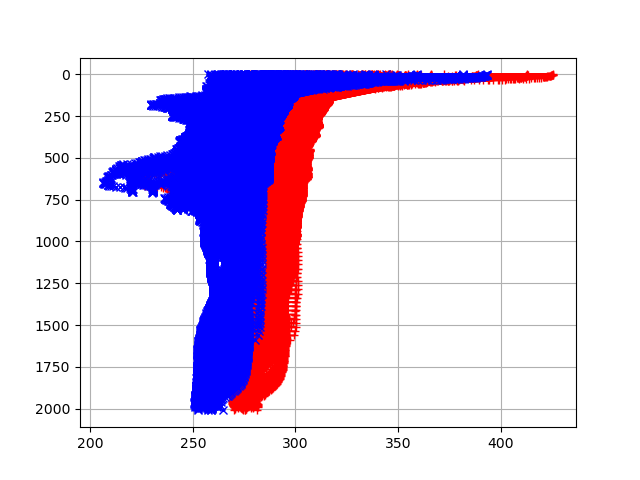

In [60]:
plt.figure()
_=plt.plot(ds_argo_Sprof['DOXY_ADJUSTED'],ds_argo_Sprof['PRES'],'+-r')
_=plt.plot(ds_argo_Sprof['DOXY'],ds_argo_Sprof['PRES'],'x-b')
plt.grid()
plt.gca().invert_yaxis()


In [61]:
ds_argo_final = ds_argo_Sprof[['DOXY_ADJUSTED','CYCLE_NUMBER','PRES']]
ds_argo_final.to_netcdf('/Users/chemon/ARGO_NEW/NEW_LOCODOX/locodox_python/fic_netcdf_test/ovid18_cor_python_V2.nc')

In [62]:
params_Gain_CTD * model_Gain_Derive([ds_argo_Sprof['DOXY'].isel(N_PROF=i).values,tab_delta_T],*params_Gain_Derive_NCEP)[0]

array([341.05118389,          nan, 340.94144885, ...,          nan,
                nan,          nan])

In [63]:
print(params_Gain_Derive_NCEP[0])
print(params_Gain_CTD)
print(params_Gain_Derive_NCEP[0]*params_Gain_CTD)
print(params_Gain_Derive_NCEP[1])

1.049934498522257
[1.01113838]
[1.06162907]
0.4974972673466156


In [65]:
#new_pres = np.arange(min_pres_interp,max_pres_interp+1,1).reshape(1,max_pres_interp+1-min_pres_interp)
#print(new_pres.shape)
#new_pres = np.tile(new_pres.transpose(),psat_argo.shape[0]).transpose()
delta_T = delta_T_WOA
nb_depth = len(ds_argo['N_LEVELS'])
nb_profil = len(ds_argo['N_PROF'])
delta_T = delta_T.reshape(nb_profil,1)
delta_T = np.tile(delta_T,nb_depth)

ana_dens = sw.pden(ds_argo['PSAL_ARGO'],ds_argo['TEMP_ARGO'],ds_argo['PRES_ARGO'],0)
O2_ARGO_umolL = umolkg_to_umolL(ds_argo['DOXY_ARGO'],ds_argo['DOXY_ARGO'].units,ana_dens)
ppox_a_corriger = O2ctoO2p(O2_ARGO_umolL,ds_argo['TEMP_ARGO'],ds_argo['PSAL_ARGO']) # On calcule PPOX pour P=0
#ppox_corr_NCEP = model_Gain(ppox_a_corriger,*params_Gain_NCEP)
ppox_corr_NCEP = model_Gain(ppox_a_corriger,*gain_CarryOver)
ppox_corr_WOA = model_Gain(ppox_a_corriger,*params_Gain_WOA)

O2_ARGO_corr_NCEP = O2ptoO2c(ppox_corr_NCEP,ds_argo['TEMP_ARGO'],ds_argo['PSAL_ARGO'])/ana_dens*1000
O2_ARGO_corr_WOA = O2ptoO2c(ppox_corr_WOA,ds_argo['TEMP_ARGO'],ds_argo['PSAL_ARGO'])/ana_dens*1000

#ppox_corr2_NCEP = model_Gain_Derive([ppox_a_corriger,delta_T],*params_Gain_Derive_NCEP)
ppox_corr2_NCEP = model_Gain_Derive([ppox_a_corriger,delta_T],*gain_Derive_CarryOver)

ppox_corr2_WOA = model_Gain_Derive([ppox_a_corriger,delta_T],*params_Gain_Derive_WOA)

O2_ARGO_corr2_NCEP = O2ptoO2c(ppox_corr2_NCEP,ds_argo['TEMP_ARGO'],ds_argo['PSAL_ARGO'])/ana_dens*1000
O2_ARGO_corr2_WOA = O2ptoO2c(ppox_corr2_WOA,ds_argo['TEMP_ARGO'],ds_argo['PSAL_ARGO'])/ana_dens*1000

In [66]:
dsctd = xr.open_dataset("/Volumes/lpo5/HYDROCEAN/OVIDE18_TEMP/CLC/ov18d081_clc.nc",engine='netcdf4')

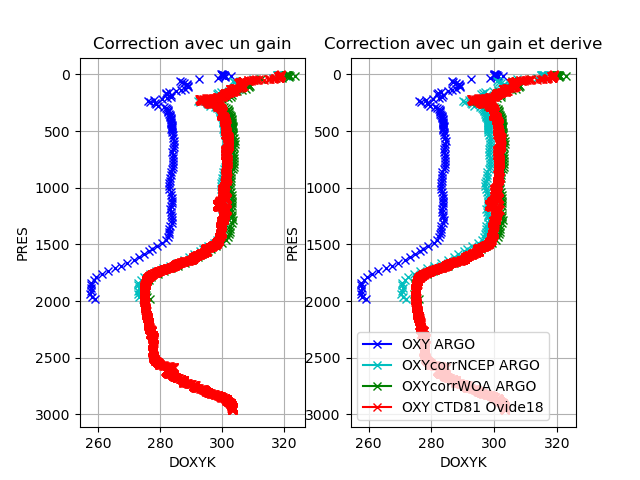

In [67]:
plt.figure()
plt.subplot(1,2,1)
_ = plt.plot(ds_argo['DOXY_ARGO'][1,:],ds_argo['PRES_ARGO'][1,:],'-xb')
plt.gca().invert_yaxis()
_ = plt.plot(O2_ARGO_corr_NCEP[1,:],ds_argo['PRES_ARGO'][1,:],'-xc')
_ = plt.plot(O2_ARGO_corr_WOA[1,:],ds_argo['PRES_ARGO'][1,:],'-xg')
plt.grid()
_ = plt.plot(dsctd['OXYK'],dsctd['PRES'],'-xr')
plt.xlabel('DOXYK')
plt.ylabel('PRES')
plt.title('Correction avec un gain')
#_ = plt.legend(['OXY ARGO','OXYcorrNCEP ARGO','OXYcorrWOA ARGO','OXY CTD81 Ovide18'],loc='lower center',bbox_to_anchor=(1,1))

plt.subplot(1,2,2)
_ = plt.plot(ds_argo['DOXY_ARGO'][1,:],ds_argo['PRES_ARGO'][1,:],'-xb')
plt.gca().invert_yaxis()
_ = plt.plot(O2_ARGO_corr2_NCEP[1,:],ds_argo['PRES_ARGO'][1,:],'-xc')
_ = plt.plot(O2_ARGO_corr2_WOA[1,:],ds_argo['PRES_ARGO'][1,:],'-xg')
plt.grid()
_ = plt.plot(dsctd['OXYK'],dsctd['PRES'],'-xr')
plt.xlabel('DOXYK')
plt.ylabel('PRES')
plt.title('Correction avec un gain et derive')
_ = plt.legend(['OXY ARGO','OXYcorrNCEP ARGO','OXYcorrWOA ARGO','OXY CTD81 Ovide18']) #,loc='upper left',bbox_to_anchor=(1,1))